In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats 
import scipy.special
from scipy.special import comb
from scipy.optimize import minimize_scalar

import scipy
import math
import time
from sklearn.gaussian_process.kernels import RBF

from itertools import product, groupby
import random, time


In [4]:
def runs(a_list):
    runs_zeros = len([k for k, g in groupby(a_list) if k == 0])
    runs_ones = len([k for k, g in groupby(a_list) if k == 1])
    return runs_ones+runs_zeros

In [5]:
ex = [0,1,1,0,1,0,1]
runs(ex)

6

In [6]:
class T0_est:  
    def __init__(self, T, x, y,K,sigma,alpha,n_sim=10000,burn=0):
        self.T= T
        self.x=x
        self.y=y
        self.K=K
        self.sigma=sigma
        self.alpha=alpha
        self.n_sim=n_sim
        self.burn=burn
        self.n = y.shape[0]
        self.g = T.shape[0]
        
        self.T0_init = np.array([0, 1] * (self.g // 2))
        
        self.too_many_rej = 0
        self.action = []
    
    def chain_builder(self):
        chain = [self.T0_init]
        for i in range(self.n_sim):
            curr=chain[-1]
            chain.append(self.next_T0(curr))
        return chain[self.burn:]
    
        
    def next_T0(self,current): 
        new = self.candidate(current)
        rate=self.acceptance_rate(current,new)
        
        if self.too_many_rej ==0:
            treshold = 1
        else:
            treshold = 0.98
            
        if rate>=treshold:
            print("Proposal T0 accepted with rate ", rate)
            self.action.append(1)
            return new
        
        else:
            print("Proposal T0 rejected with rate ", rate)
            self.action.append(0)
            
            if sum(self.action[-10:-1])==0:
                self.too_many_rej = 1
            else:
                self.too_many_rej = 0
                
            return current
        
    def candidate(self,old):
        new=old.copy()
        coin = np.random.uniform(0,1,1)
        
        if coin<0.2: #split
            choices = [i for i in range(1,len(old) - 1) if old[i-1] == 1 and old[i] == 1 and old[i + 1] == 1]
            if len(choices)>0:
                choice = np.random.choice(choices)
                splitting_point = choice
                new[splitting_point]=0
        
        if (coin>=0.2) and (coin<0.4): #right removal
            choices = [i for i in range(0,len(old)-1) if old[i] == 1 and old[i + 1] == 0]
            if len(choices)>0:
                choice = np.random.choice(choices)
                removing_point = choice
                new[removing_point]=0
        
        if (coin>=0.4) and (coin<0.6): #left removal
            choices = [i+1 for i in range(0,len(old)-1) if old[i] == 0 and old[i + 1] == 1]
            if len(choices)>0:
                choice = np.random.choice(choices)
                removing_point = choice
                new[removing_point]=0
        
        if (coin>=0.6) and (coin<0.8): #right add
            choices = [i for i in range(1,len(old)) if old[i-1] == 1 and old[i] == 0]
            if len(choices)>0:
                choice = np.random.choice(choices)
                adding_point = choice
                new[adding_point]=1

        if coin>=0.8: #left add
            choices = [i for i in range(0,len(old)-1) if old[i] == 0 and old[i + 1] == 1]
            if len(choices)>0:
                choice = np.random.choice(choices)
                adding_point = choice
                new[adding_point]=1

        
        return new
        
    
    def acceptance_rate(self,current,new):   
        prior = self.PT0(current)
        prior_new = self.PT0(new)
        likl = posterior(self.T,current,self.x,self.y,self.K,self.sigma).likelihood()
        likl_new =posterior(self.T,new,self.x,self.y,self.K,self.sigma).likelihood()
        
        return (likl_new*prior_new)/(likl*prior)
            
    
    def PT0(self,current): 
        r=runs(current)          
        return np.exp(-self.alpha*r)



# Class posterior:
The implementation of this class follows 007_2 notebook with the addition of **likelihood()** method which evaluates p(Y|T0)

In [7]:
class posterior:
    def __init__(self, T, T0, x, y, K,sigma):
        self.T = T
        self.x = x
        self.y = y
        self.n = y.shape[0]
        self.g = T.shape[0]
        self.T0 = T0
        self.sigma = sigma
        self.K = K
        self.K0 = self.get_K0()
        
    def get_K0(self):
        tau = np.where(self.T0==1)[0]
        print(len(tau))
        K_tau=self.K[:, tau]
        K_tau_tau = self.K[tau[:, None], tau]
        return self.K- K_tau @ np.linalg.inv(K_tau_tau)@ K_tau.T              
        
    def Lx0(self,t):   
        L = np.zeros(self.n)    
        for i in np.arange(0,self.n):
            L[i] = np.trapz(self.K0[t, :] * self.x[i,:], self.T)
        return L
    
    def R0(self,i, j):
        Ri = np.trapz(self.K0[:, :] * self.x[i, :], self.T, axis=1)
        Rij = np.trapz(Ri * self.x[j, :],self.T)
        return Rij

    def M(self):
        return np.array([[self.R0(i, j) for j in range(self.n)] for i in range(self.n)])+np.identity(self.n)
    

    def likelihood(self): #p(Y|T0) 
        m_matrix = self.M()
        first = np.linalg.det(m_matrix) ** (-0.5)

        
        inv = np.linalg.inv(m_matrix)
        s11 = np.dot(np.dot(np.transpose(np.ones(self.n)),inv),np.ones(self.n))
        
        syy = np.dot(np.dot(np.transpose(self.y),inv),self.y)
        s1y = np.dot(np.dot(np.transpose(np.ones(self.n)),inv),self.y)
        b = 0.5*(syy-s1y**2/s11)
            
        return first/np.sqrt(s11)*(b**(-0.5*(n-1)))


## Example

In [9]:
g=128
T = np.linspace(-3,3,g)
T0_real = T[np.where((T >= -1) & (T <= 0.5))]

T0_01 = np.zeros(g)
for i in range(g):
    if (T[i]>=-1) and (T[i]<=0.5):
        T0_01[i]=1


step = T[1]-T[0]
n = 30
alpha = 4
sigma = 0.25

def integrate(T, f): 
    tot = 0;
    for i in range(len(T)-1):
        tot = tot + (1/2 * (f[i]+f[i+1]) * (T[1]-T[0]))
    return tot

def prior_kernel(s,t):
    return np.exp(-2*(t-s)**2)+0.0001*(s==t)

def proj(K,T,T0,f): 
    tau = np.where(T0==1)[0]
    K_tau=K[:, tau]
    K_tau_tau = K[tau[:, None], tau]
    beta_tau = f[tau] 
    
    proj = f-np.dot(K_tau,np.dot(np.linalg.inv(K_tau_tau),beta_tau))
    
    return proj

K = np.zeros((g, g))
K = np.fromfunction(np.vectorize(lambda s, t: prior_kernel(T[s], T[t])), (g, g), dtype=int) 
x = np.random.multivariate_normal(np.zeros(g), K, n)


In [10]:
beta = np.sin(T*math.pi/4)
beta0 = proj(K,T,T0_01,beta)

y = np.zeros(n)
y = np.fromfunction(np.vectorize(lambda i: integrate(T,  x[i,:]*beta0)+np.random.normal(0,sigma,1)), (n,), dtype=int)

In [ ]:
post = T0_est(T, x, y, K, sigma, alpha, 5000)

chain = post.chain_builder()

64
65
Proposal T0 accepted with rate  2980.8381234369044
65
64
Proposal T0 accepted with rate  2981.058528764342
64
63
Proposal T0 rejected with rate  0.0003354758871646607
64
63
Proposal T0 accepted with rate  2981.229780189108
63
62
Proposal T0 rejected with rate  0.0003354794635989217
63
62
Proposal T0 accepted with rate  2981.4713374929856
62
61
Proposal T0 rejected with rate  0.00033547947696999715
62
63
Proposal T0 accepted with rate  2980.625293424886
63
64
Proposal T0 accepted with rate  2980.8692938427776
64
65
Proposal T0 accepted with rate  2980.97076114439
65
64
Proposal T0 rejected with rate  0.00033546119037279707
65
66
Proposal T0 accepted with rate  2980.969311124851
66
65
Proposal T0 accepted with rate  2981.6730419123896
65
66
Proposal T0 accepted with rate  2980.708625467583
66
67
Proposal T0 accepted with rate  2980.8641353407265
67
66
Proposal T0 accepted with rate  2981.063445035483
66
67
Proposal T0 accepted with rate  2980.985222268166
67
66
Proposal T0 rejected

Proposal T0 rejected with rate  0.9999253439420848
48
47
Proposal T0 accepted with rate  1.0046993073229413
47
46
Proposal T0 accepted with rate  1.0020968522624347
46
45
Proposal T0 accepted with rate  1.005341223475537
45
44
Proposal T0 accepted with rate  1.002483264333081
44
43
Proposal T0 rejected with rate  0.00033551629427597333
44
45
Proposal T0 rejected with rate  0.9997856145286557
44
43
Proposal T0 rejected with rate  0.9998931902071303
44
43
Proposal T0 rejected with rate  0.9998931902071303
44
45
Proposal T0 rejected with rate  0.9991011392061505
44
43
Proposal T0 rejected with rate  0.999948836259679
44
45
Proposal T0 rejected with rate  0.9999493461539135
44
45
Proposal T0 rejected with rate  0.9991011392061505
44
43
Proposal T0 accepted with rate  1.0016119417280638
43
44
Proposal T0 rejected with rate  0.9997918053233198
43
42
Proposal T0 rejected with rate  0.00033554685985548953
43
42
Proposal T0 rejected with rate  0.00033546384166010965
43
42
Proposal T0 rejected w

23
Proposal T0 accepted with rate  1.0397804808979374
23
22
Proposal T0 rejected with rate  0.00033556522742437037
23
22
Proposal T0 rejected with rate  0.00033447861699143194
23
24
Proposal T0 rejected with rate  0.9352074888231438
23
24
Proposal T0 accepted with rate  1.0071956440253784
24
23
Proposal T0 accepted with rate  1.0004464507625206
23
22
Proposal T0 rejected with rate  0.00033571351601640936
23
24
Proposal T0 accepted with rate  1.0180040649362774
24
23
Proposal T0 accepted with rate  1.0264617101996774
23
24
Proposal T0 accepted with rate  1.006513346627802
24
23
Proposal T0 rejected with rate  0.9955708650013737
24
25
Proposal T0 rejected with rate  0.8160625485691653
24
25
Proposal T0 rejected with rate  0.9339717455890014
24
23
Proposal T0 accepted with rate  246923.22892342263
23
22
Proposal T0 accepted with rate  1.00140455086798
22
21
Proposal T0 rejected with rate  0.00033508310660584423
22
21
Proposal T0 rejected with rate  0.0003336013144825278
22
23
Proposal T0 

9
Proposal T0 accepted with rate  1.030014564870166
9
8
Proposal T0 rejected with rate  0.9534437303700506
9
8
Proposal T0 rejected with rate  0.9619537218976821
9
10
Proposal T0 accepted with rate  1.008779049073071
10
11
Proposal T0 rejected with rate  0.9814311776767928
10
11
Proposal T0 rejected with rate  0.9814311776767928
10
9
Proposal T0 rejected with rate  0.9515126411859373
10
11
Proposal T0 rejected with rate  0.9814311776767928
10
9
Proposal T0 rejected with rate  0.00033635472927104186
10
9
Proposal T0 rejected with rate  0.9515126411859373
10
9
Proposal T0 rejected with rate  0.9947707610500955
10
9
Proposal T0 accepted with rate  1.0086975328471346
9
8
Proposal T0 rejected with rate  0.00033704376932043535
9
10
Proposal T0 rejected with rate  0.9359678017765508
9
10
Proposal T0 rejected with rate  0.9766159744069824
9
8
Proposal T0 rejected with rate  0.6932008941260803
9
8
Proposal T0 rejected with rate  0.6932008941260803
9
8
Proposal T0 rejected with rate  0.993413795

7
Proposal T0 rejected with rate  0.6262301169643292
8
7
Proposal T0 rejected with rate  0.9369703577963644
8
9
Proposal T0 accepted with rate  1.00387332745427
9
8
Proposal T0 rejected with rate  0.0003371231208879403
9
8
Proposal T0 rejected with rate  0.6590579690350706
9
8
Proposal T0 rejected with rate  0.0003381044341299315
9
10
Proposal T0 rejected with rate  0.9632042905780672
9
10
Proposal T0 rejected with rate  0.9906527247794654
9
8
Proposal T0 rejected with rate  0.0003337385456936828
9
8
Proposal T0 rejected with rate  0.000337800411679288
9
8
Proposal T0 rejected with rate  0.000335622409122375
9
10
Proposal T0 rejected with rate  0.9954158833222909
9
10
Proposal T0 rejected with rate  0.9954158833222909
9
8
Proposal T0 rejected with rate  0.6534445806350777
9
10
Proposal T0 rejected with rate  0.9632042905780672
9
8
Proposal T0 rejected with rate  0.6590579690350706
9
10
Proposal T0 rejected with rate  0.9566242069636555
9
8
Proposal T0 rejected with rate  0.975444784884

Proposal T0 accepted with rate  0.9913637318560087
10
9
Proposal T0 accepted with rate  0.9941774141463081
9
8
Proposal T0 accepted with rate  1.0065900330601907
8
7
Proposal T0 rejected with rate  0.0003367114576116738
8
7
Proposal T0 rejected with rate  0.0003323281525467765
8
7
Proposal T0 rejected with rate  0.9346195860684426
8
7
Proposal T0 rejected with rate  0.9346195860684426
8
7
Proposal T0 rejected with rate  0.9346195860684426
8
7
Proposal T0 rejected with rate  0.6338494820587031
8
9
Proposal T0 accepted with rate  1.00387332745427
9
8
Proposal T0 rejected with rate  0.000337800411679288
9
8
Proposal T0 rejected with rate  0.6590579690350706
9
10
Proposal T0 rejected with rate  0.9954158833222909
9
8
Proposal T0 rejected with rate  0.6534445806350777
9
8
Proposal T0 rejected with rate  0.000337800411679288
9
8
Proposal T0 rejected with rate  0.0003381044341299315
9
8
Proposal T0 rejected with rate  0.000337800411679288
9
8
Proposal T0 rejected with rate  0.9754447848848389

7
Proposal T0 rejected with rate  0.9263643104423486
8
9
Proposal T0 accepted with rate  1.0112548994385806
9
8
Proposal T0 rejected with rate  0.0003374031912230754
9
8
Proposal T0 rejected with rate  0.6366671069048424
9
8
Proposal T0 rejected with rate  0.0003382756962567062
9
10
Proposal T0 rejected with rate  0.9643127114009955
9
8
Proposal T0 rejected with rate  0.0003374031912230754
9
10
Proposal T0 rejected with rate  0.9643127114009955
9
10
Proposal T0 rejected with rate  0.9913637318560087
9
8
Proposal T0 rejected with rate  0.6507845302381349
9
10
Proposal T0 rejected with rate  0.9643127114009955
9
8
Proposal T0 rejected with rate  0.0003360090278957945
9
8
Proposal T0 rejected with rate  0.6507845302381349
9
10
Proposal T0 rejected with rate  0.9501601452201992
9
8
Proposal T0 rejected with rate  0.9792490441661253
9
10
Proposal T0 rejected with rate  0.975550326667958
9
10
Proposal T0 rejected with rate  0.9501601452201992
9
8
Proposal T0 rejected with rate  0.65078453023

Proposal T0 rejected with rate  0.6366671069048424
9
10
Proposal T0 rejected with rate  0.9643127114009955
9
10
Proposal T0 rejected with rate  0.975550326667958
9
8
Proposal T0 rejected with rate  0.6366671069048424
9
8
Proposal T0 rejected with rate  0.6507845302381349
9
8
Proposal T0 rejected with rate  0.6366671069048424
9
8
Proposal T0 rejected with rate  0.6507845302381349
9
10
Proposal T0 rejected with rate  0.975550326667958
9
8
Proposal T0 rejected with rate  0.0003336040285223585
9
8
Proposal T0 rejected with rate  0.9792490441661253
9
10
Proposal T0 rejected with rate  0.9643127114009955
9
10
Proposal T0 rejected with rate  0.9501601452201992
9
8
Proposal T0 rejected with rate  0.0003382756962567062
9
8
Proposal T0 rejected with rate  0.0003374031912230754
9
10
Proposal T0 rejected with rate  0.9501601452201992
9
8
Proposal T0 rejected with rate  0.9792490441661253
9
10
Proposal T0 rejected with rate  0.9643127114009955
9
10
Proposal T0 accepted with rate  0.9913637318560087

9
Proposal T0 rejected with rate  0.9727357155970264
8
9
Proposal T0 accepted with rate  1.0112548994385806
9
10
Proposal T0 rejected with rate  0.9913637318560087
9
8
Proposal T0 rejected with rate  0.0003336040285223585
9
10
Proposal T0 rejected with rate  0.9643127114009955
9
8
Proposal T0 rejected with rate  0.9888703635010035
9
10
Proposal T0 rejected with rate  0.9913637318560087
9
10
Proposal T0 rejected with rate  0.9501601452201992
9
8
Proposal T0 rejected with rate  0.6366671069048424
9
8
Proposal T0 rejected with rate  0.6507845302381349
9
10
Proposal T0 rejected with rate  0.9501601452201992
9
8
Proposal T0 rejected with rate  0.9792490441661253
9
10
Proposal T0 rejected with rate  0.975550326667958
9
10
Proposal T0 rejected with rate  0.975550326667958
9
8
Proposal T0 rejected with rate  0.9792490441661253
9
8
Proposal T0 rejected with rate  0.0003376741625626074
9
10
Proposal T0 rejected with rate  0.9501601452201992
9
10
Proposal T0 rejected with rate  0.9643127114009955

8
Proposal T0 rejected with rate  0.6507845302381349
9
8


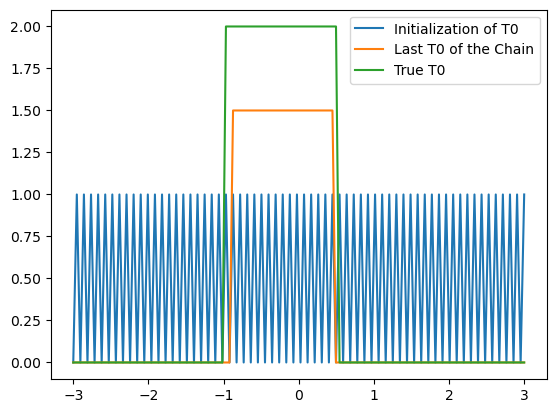

In [65]:
plt.plot(T,post.T0_init,label='Initialization of T0')
plt.plot(T,1.5*np.array(chain[-1]),label='Last T0 of the Chain')
plt.plot(T,2*T0_01,label='True T0')
plt.legend()

In [ ]:
T0_hat, counts = stats.mode(chain, axis=0)
idxs = np.where(T0_hat==1)

In [ ]:
idxs

In [ ]:
T[idxs[1][0]]